# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [2]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
random.seed(42)

# Load data

In [5]:
dataset_df = pd.read_csv('kaggle_dataset/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (94477, 4)


In [6]:
dataset_df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [7]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from first row
    path, sequence_id, sign = dataset_df.sample(n=1).iloc[0][['path', 'sequence_id', 'sign']]
    print(f"sequence_id: {sequence_id}, path: {path}, sign: {sign}")
    
    # Fetch data from parquet file (This dataset stores each landmark in a separate row)
    sample_sequence_df_wrong_format = pq.read_table(f"kaggle_dataset/{path}",).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df_wrong_format.shape))
    
    return sample_sequence_df_wrong_format

In [8]:
random_sequence()

sequence_id: 2676149049, path: train_landmark_files/61333/2676149049.parquet, sign: animal
Full sequence dataset shape is (14118, 7)


,frame,row_id,type,landmark_index,x,y,z
0,29,29-face-0,face,0,0.328956,0.416983,-0.040202
1,29,29-face-1,face,1,0.316552,0.381807,-0.067215
2,29,29-face-2,face,2,0.322737,0.392862,-0.038068
3,29,29-face-3,face,3,0.305238,0.350147,-0.045894
4,29,29-face-4,face,4,0.314587,0.371254,-0.070492
...,...,...,...,...,...,...,...
14113,54,54-right_hand-16,right_hand,16,NaN,NaN,NaN
14114,54,54-right_hand-17,right_hand,17,NaN,NaN,NaN
14115,54,54-right_hand-18,right_hand,18,NaN,NaN,NaN
14116,54,54-right_hand-19,right_hand,19,NaN,NaN,NaN


In [9]:
# Check if all frames contain all coords
# for i, row in tqdm(dataset_df.iterrows()):
#     path, sequence_id, sign = row[['path', 'sequence_id', 'sign']].values
#     l = len(pq.read_table(f"kaggle_dataset/{path}",).to_pandas())
#     if l % 543 != 0:
#         print(l/543)

In [10]:
NUM_COORDS_FRAME = 543

def gen_column_names(prefix: str, name: str, count: int):
    col_names = []
    for i in range(0, count+1):
        col_names.append(f"{prefix}_{name}_{i}")
    return col_names

columns = list(chain(
    gen_column_names("x", "face", 467),
    gen_column_names("x", "left_hand", 20),
    gen_column_names("x", "pose", 32),
    gen_column_names("x", "right_hand", 20),
    gen_column_names("y", "face", 467),
    gen_column_names("y", "left_hand", 20),
    gen_column_names("y", "pose", 32),
    gen_column_names("y", "right_hand", 20),
    gen_column_names("z", "face", 467),
    gen_column_names("z", "left_hand", 20),
    gen_column_names("z", "pose", 32),
    gen_column_names("z", "right_hand", 20),
))

# Transform the dataframe to be tha same format as the fingerspelling dataset (1 row for each frame)
def transform_df(df):
    x = df.x
    y = df.y
    z = df.z

    num_frames = len(df) // NUM_COORDS_FRAME
    x = x.values.reshape(num_frames, NUM_COORDS_FRAME)
    y = y.values.reshape(num_frames, NUM_COORDS_FRAME)
    z = z.values.reshape(num_frames, NUM_COORDS_FRAME)

    data = np.concatenate((x, y, z), axis=1)
        
    return pd.DataFrame(data, columns=columns)

In [11]:
%%time
transform_df(random_sequence()).head()

sequence_id: 638753480, path: train_landmark_files/16069/638753480.parquet, sign: cereal
Full sequence dataset shape is (22263, 7)
CPU times: total: 15.6 ms
Wall time: 54.9 ms


,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,x_face_9,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
0,0.506479,0.504173,0.503909,0.497116,0.505175,0.506901,0.511190,0.419370,0.514546,0.516208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.503622,0.507063,0.506773,0.499183,0.507865,0.509246,0.512718,0.419568,0.515507,0.516889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.503759,0.503124,0.504161,0.496303,0.503926,0.505821,0.511099,0.418734,0.514681,0.516310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.508439,0.501275,0.503539,0.494720,0.501735,0.503667,0.509617,0.418714,0.513388,0.514932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.515268,0.490611,0.494156,0.486140,0.491106,0.493903,0.502357,0.417210,0.506981,0.508655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Animation preview

In [80]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [81]:
video = produce_video_from_seq(transform_df(random_sequence()))
create_animation(video)

sequence_id: 4156906371, path: train_landmark_files/55372/4156906371.parquet, sign: kitty
Full sequence dataset shape is (17376, 7)


# Statistics

In [82]:
def lengths_hist(lengths: list, title="", space=50):
    plt.hist(lengths, np.linspace(0, space, space))
    plt.ylim(plt.ylim())
    max_length = max(lengths)
    plt.plot([max_length, max_length], plt.ylim())
    plt.title(f'{title} (Max: {max_length})')
    plt.show()

def calc_percentiles(values: list, percentiles=[25, 50,75, 80, 90]):
    percentile_values = np.percentile(values, percentiles)
    for p, value in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {value}")

## Statistics on the length of sequences:

This is an extremely long operation, and therefor only performed on a random subset of whole data.

In [124]:
seq_lengths = []

for file_path in tqdm(dataset_df.sample(n=3000).path):
    count = pq.read_table("kaggle_dataset/" + file_path, columns=['frame']).num_rows
    seq_lengths.append(count // NUM_COORDS_FRAME)

  0%|          | 0/3000 [00:00<?, ?it/s]

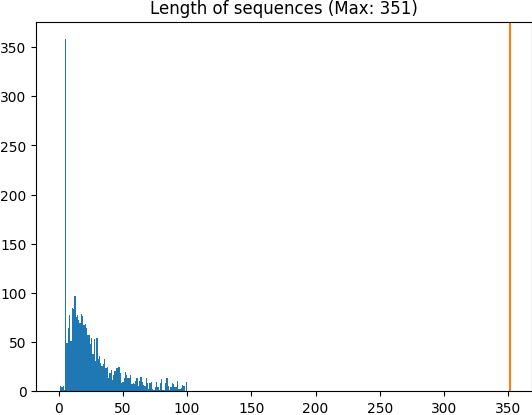

25th percentile: 12.0
50th percentile: 22.0
75th percentile: 44.0
80th percentile: 52.0
90th percentile: 92.0


In [125]:
lengths_hist(seq_lengths, "Length of sequences", 100)
calc_percentiles(seq_lengths)

For single signs Extremely long sequences are suspicious. It might be beneficial to cut those off from the training data.

# Save to TFRecords

In [12]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
FPOSE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
POSE = LPOSE + RPOSE + FPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
FPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in FPOSE]

MID_POINT_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) == 1]

In [13]:
def save_tfrecords_to(folder: str):
    for part_id, group_df in tqdm(dataset_df.groupby(by="participant_id")):
        # Save each participant's data into separate files
        tf_file = f"{folder}/{part_id}.tfrecord"
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            for file_path, sign in tqdm(zip(group_df.path, group_df.sign)):
                pq_file = pq.read_table(f"kaggle_dataset/{file_path}",columns=["x", "y", "z"])

                df_original_format = pq_file.to_pandas()
                formatted_df = transform_df(df_original_format)
                frames = formatted_df.values

                features = {formatted_df.columns[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(formatted_df.columns))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(sign, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

In [14]:
folder_name = "train_tfrecords_all_coords"
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
    save_tfrecords_to(folder_name)
else:
    print(f"Warning: Tfrecords already exist! Delete the {folder_name} folder to regenerate them!")

# Fetch from TFRecords

In [15]:
tf_records = dataset_df.participant_id.map(lambda x: f'{folder_name}/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 21 TFRecord files.


In [16]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [17]:
sorted_signs = sorted(set(dataset_df.sign))
sign_to_num = {sign : i for i, sign in enumerate(sorted_signs)}
num_to_sign = {i : sign for sign, i in sign_to_num.items()}

In [18]:
MAX_FRAME_LEN = 64
FEATURE_LEN = len(FEATURE_COLUMNS)//3
CHANNELS = 6*FEATURE_LEN

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))
   
def preprocess_landmarks(inp):
    x = inp[:, 0*FEATURE_LEN: 1*FEATURE_LEN]
    y = inp[:, 1*FEATURE_LEN : 2*FEATURE_LEN]
    z = inp[:, 2*FEATURE_LEN : 3*FEATURE_LEN]
    x = tf.concat([x[..., tf.newaxis], y[..., tf.newaxis], z[..., tf.newaxis]], axis=-1)
    # x.shape == (T, P, C) or (N, T, P, C)
    # N: Batch size
    # T: Sequence length
    # P: Number of points (or landmarks)
    # C: Number of channels (features) per point
    
    if tf.rank(x) == 3:
        x = x[None,...]
    # x.shape == (N, T, P, C)
    
    # Mean of midpoints through timesteps
    mean = tf_nan_mean(tf.gather(x, [MID_POINT_IDX[0]], axis=2), axis=[1,2], keepdims=True)
    mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
    # x.shape == (N, 1, 1, C)
    
    # Filtering for relevant points goes here
    # I only saved the relevant ones by chance so experiment with other combinations
    
    std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
    # std.shape == (N, 1, 1, C)
    
    x = (x - mean)/std
    # x.shape == (N, T, P, C)
    
    if MAX_FRAME_LEN is not None:
        x = x[:,:MAX_FRAME_LEN]
    seq_length = tf.shape(x)[1]
    x = x[...,:2]
    # x.shape == (N, T, P, 2)

    # Calc differences between consequtive frames and with skipping 1 in between
    dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    # dx.shape == dx2.shape == (N, T, P, 2)
    
    x = tf.concat([
        tf.reshape(x, (-1,seq_length,2*FEATURE_LEN)),
        tf.reshape(dx, (-1,seq_length,2*FEATURE_LEN)),
        tf.reshape(dx2, (-1,seq_length,2*FEATURE_LEN)),
    ], axis = -1)
    # x.shape == (N, T, 6*FEATURE_LEN) where T <= MAX_FRAME_LEN
    
    # Replace NaN values with zeros
    x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
    
    return x[0]

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(sign_to_num.keys()),
        values=list(sign_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="signs"
)

def preprocess_phrase(phrase):
    return table.lookup(phrase)

def preprocess(landmarks, phrase):
    return preprocess_landmarks(landmarks), preprocess_phrase(phrase)

In [19]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

PAD = -100.
NUM_CLASSES = len(sign_to_num)

def get_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False, cache=False):
    ds = tf.data.TFRecordDataset(tf_records)
    ds = ds.map(decode_fn, tf.data.AUTOTUNE)
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
        
    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=(PAD, -1), padded_shapes=([MAX_FRAME_LEN, CHANNELS],[]), drop_remainder=drop_remainder)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    if cache:
        ds = ds.cache()
    
    return ds

train_ds = get_dataset(tf_records[:train_len], batch_size=batch_size, cache=True)
valid_ds = get_dataset(tf_records[train_len:], batch_size=batch_size, cache=True)

In [20]:
train_iterator = iter(train_ds)

print("Training Data:")
landmarks, phrase = next(train_iterator)
lm_shape = landmarks.shape[2]

print("Landmarks:")
print(type(landmarks))
print(landmarks.shape)
print(landmarks.numpy())
print("-" * 40)
print("Phrase:")
print(phrase.shape)
print(phrase)
print("-" * 40)

Training Data:
Landmarks:
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 64, 372)
[[[-8.46946478e-01  7.90750146e-01 -6.50168478e-01 ... -3.84567678e-03
   -1.35350227e-02 -2.71488726e-03]
  [-8.23016584e-01  7.13746965e-01 -6.19235396e-01 ...  7.18310475e-04
   -1.05634928e-02  2.44282186e-03]
  [-8.01483691e-01  6.73875570e-01 -5.74451506e-01 ...  9.53376293e-05
    1.93512440e-03  1.11070275e-03]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-9.77546096e-01  8.21505725e-01 -7.48384178e-01 ...  1.36579275e-02
   -1.77093446e-02  2.47002244e-02]
  [-9.26388502e-01  7.99359977e-01 -6.90003514e-01 ...  3.62835526e-02
   -2.63395160e-02  3.96442413e-02]
  [-8.13614905e-01  7.32428432e-01 -5.7670

In [21]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x

def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [22]:
lm_seq, sing_idx = next(iter(train_ds))

In [23]:
def get_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

In [24]:
model = get_model()
y = model(lm_seq)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 372)]            0         []                            
                                                                                                  
 masking (Masking)           (None, 64, 372)              0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Dense)           (None, 64, 192)              71424     ['masking[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 192)              768       ['stem_conv[0][0]']           
 n)                                                                                           

In [25]:
#check supports_masking
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)

In [26]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"])

In [29]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='first_run_till_its_dead.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2
)

In [ ]:
%%time
model.fit(train_ds,
                validation_data=valid_ds,
                epochs=50,
                callbacks=[checkpoint_callback],
                verbose = 2)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.66342, saving model to first_run_till_its_dead.h5
1477/1477 - 1083s - loss: 1.3421 - accuracy: 0.6684 - val_loss: 1.6634 - val_accuracy: 0.5941 - 1083s/epoch - 733ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.66342 to 1.60600, saving model to first_run_till_its_dead.h5
1477/1477 - 1086s - loss: 1.3342 - accuracy: 0.6705 - val_loss: 1.6060 - val_accuracy: 0.6062 - 1086s/epoch - 735ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.60600
1477/1477 - 1086s - loss: 1.3132 - accuracy: 0.6739 - val_loss: 1.6472 - val_accuracy: 0.6008 - 1086s/epoch - 735ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.60600
1477/1477 - 1088s - loss: 1.2944 - accuracy: 0.6779 - val_loss: 1.6303 - val_accuracy: 0.6031 - 1088s/epoch - 736ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.60600
1477/1477 - 1085s - loss: 1.2855 - accuracy: 0.6801 - val_loss: 1.6808 - val_accuracy: 0.5973 - 1085s/epoch - 735ms/step
Epoch 6/

In [ ]:
Epoch 1/30
1477/1477 - 1180s - loss: 4.5500 - accuracy: 0.1066 - val_loss: 4.3412 - val_accuracy: 0.1378 - 1180s/epoch - 799ms/step
Epoch 2/30
1477/1477 - 1108s - loss: 3.2272 - accuracy: 0.2738 - val_loss: 3.5725 - val_accuracy: 0.2328 - 1108s/epoch - 750ms/step
Epoch 3/30
1477/1477 - 1103s - loss: 2.7352 - accuracy: 0.3645 - val_loss: 3.0767 - val_accuracy: 0.3074 - 1103s/epoch - 747ms/step
Epoch 4/30
1477/1477 - 1082s - loss: 2.4660 - accuracy: 0.4197 - val_loss: 2.7925 - val_accuracy: 0.3646 - 1082s/epoch - 732ms/step
Epoch 5/30
1477/1477 - 1201s - loss: 2.2816 - accuracy: 0.4596 - val_loss: 2.6877 - val_accuracy: 0.3908 - 1201s/epoch - 813ms/step
Epoch 6/30
1477/1477 - 1197s - loss: 2.1450 - accuracy: 0.4892 - val_loss: 2.5647 - val_accuracy: 0.4107 - 1197s/epoch - 810ms/step
Epoch 7/30
1477/1477 - 1170s - loss: 2.0405 - accuracy: 0.5119 - val_loss: 2.4743 - val_accuracy: 0.4314 - 1170s/epoch - 792ms/step
Epoch 8/30
1477/1477 - 1191s - loss: 1.9570 - accuracy: 0.5312 - val_loss: 2.4346 - val_accuracy: 0.4371 - 1191s/epoch - 806ms/step
Epoch 9/30
1477/1477 - 1184s - loss: 1.8853 - accuracy: 0.5469 - val_loss: 2.1415 - val_accuracy: 0.4971 - 1184s/epoch - 802ms/step
Epoch 10/30
1477/1477 - 1179s - loss: 1.8234 - accuracy: 0.5605 - val_loss: 2.1300 - val_accuracy: 0.4980 - 1179s/epoch - 798ms/step
Epoch 11/30
1477/1477 - 1200s - loss: 1.7691 - accuracy: 0.5715 - val_loss: 2.0658 - val_accuracy: 0.5091 - 1200s/epoch - 813ms/step
Epoch 12/30
1477/1477 - 1194s - loss: 1.7199 - accuracy: 0.5840 - val_loss: 2.0106 - val_accuracy: 0.5179 - 1194s/epoch - 808ms/step
Epoch 13/30
1477/1477 - 1128s - loss: 1.6762 - accuracy: 0.5934 - val_loss: 2.1291 - val_accuracy: 0.5048 - 1128s/epoch - 764ms/step
Epoch 14/30
1477/1477 - 1109s - loss: 1.6447 - accuracy: 0.6004 - val_loss: 1.9561 - val_accuracy: 0.5282 - 1109s/epoch - 751ms/step
Epoch 15/30
1477/1477 - 1141s - loss: 1.6098 - accuracy: 0.6083 - val_loss: 1.8884 - val_accuracy: 0.5416 - 1141s/epoch - 773ms/step
Epoch 16/30
1477/1477 - 1116s - loss: 1.5770 - accuracy: 0.6149 - val_loss: 1.9441 - val_accuracy: 0.5358 - 1116s/epoch - 756ms/step
Epoch 17/30
1477/1477 - 1103s - loss: 1.5417 - accuracy: 0.6236 - val_loss: 1.9331 - val_accuracy: 0.5407 - 1103s/epoch - 747ms/step
Epoch 18/30
1477/1477 - 1113s - loss: 1.5212 - accuracy: 0.6289 - val_loss: 1.8830 - val_accuracy: 0.5539 - 1113s/epoch - 753ms/step
Epoch 19/30
1477/1477 - 1143s - loss: 1.4875 - accuracy: 0.6352 - val_loss: 1.8210 - val_accuracy: 0.5649 - 1143s/epoch - 774ms/step
Epoch 20/30
1477/1477 - 1147s - loss: 1.4679 - accuracy: 0.6409 - val_loss: 1.8804 - val_accuracy: 0.5562 - 1147s/epoch - 777ms/step
Epoch 21/30
1477/1477 - 1091s - loss: 1.4456 - accuracy: 0.6445 - val_loss: 1.7605 - val_accuracy: 0.5753 - 1091s/epoch - 739ms/step
Epoch 22/30
1477/1477 - 1101s - loss: 1.4204 - accuracy: 0.6495 - val_loss: 1.9000 - val_accuracy: 0.5524 - 1101s/epoch - 746ms/step
Epoch 23/30
1477/1477 - 1103s - loss: 1.4048 - accuracy: 0.6543 - val_loss: 1.6840 - val_accuracy: 0.5924 - 1103s/epoch - 747ms/step
Epoch 24/30
1477/1477 - 1101s - loss: 1.3749 - accuracy: 0.6603 - val_loss: 1.7241 - val_accuracy: 0.5877 - 1101s/epoch - 745ms/step
Epoch 25/30
Epoch 1/50

Epoch 1: val_loss improved from inf to 1.66342, saving model to first_run_till_its_dead.h5
1477/1477 - 1083s - loss: 1.3421 - accuracy: 0.6684 - val_loss: 1.6634 - val_accuracy: 0.5941 - 1083s/epoch - 733ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.66342 to 1.60600, saving model to first_run_till_its_dead.h5
1477/1477 - 1086s - loss: 1.3342 - accuracy: 0.6705 - val_loss: 1.6060 - val_accuracy: 0.6062 - 1086s/epoch - 735ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.60600
1477/1477 - 1086s - loss: 1.3132 - accuracy: 0.6739 - val_loss: 1.6472 - val_accuracy: 0.6008 - 1086s/epoch - 735ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.60600
1477/1477 - 1088s - loss: 1.2944 - accuracy: 0.6779 - val_loss: 1.6303 - val_accuracy: 0.6031 - 1088s/epoch - 736ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.60600
1477/1477 - 1085s - loss: 1.2855 - accuracy: 0.6801 - val_loss: 1.6808 - val_accuracy: 0.5973 - 1085s/epoch - 735ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.60600 to 1.58771, saving model to first_run_till_its_dead.h5
1477/1477 - 1090s - loss: 1.2688 - accuracy: 0.6855 - val_loss: 1.5877 - val_accuracy: 0.6115 - 1090s/epoch - 738ms/step
Epoch 7/50
...

Epoch 31: val_loss improved from 1.48126 to 1.47295, saving model to first_run_till_its_dead.h5
1477/1477 - 1087s - loss: 1.0260 - accuracy: 0.7412 - val_loss: 1.4730 - val_accuracy: 0.6512 - 1087s/epoch - 736ms/step

In [28]:
model.save_weights("kaggle_model_finally.h5")

In [ ]:
MAX_FRAME_LEN=128
4 x
x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
x = TransformerBlock(dim,expand=2)(x)

Epoch 1: val_loss improved from inf to 4.67136, saving model to kaggle_model_128_max_len.h5
739/739 - 874s - loss: 4.9859 - accuracy: 0.0719 - val_loss: 4.6714 - val_accuracy: 0.1189 - 874s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss improved from 4.67136 to 3.85239, saving model to kaggle_model_128_max_len.h5
739/739 - 788s - loss: 3.4317 - accuracy: 0.2299 - val_loss: 3.8524 - val_accuracy: 0.2181 - 788s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss improved from 3.85239 to 3.34678, saving model to kaggle_model_128_max_len.h5
739/739 - 787s - loss: 2.7430 - accuracy: 0.3528 - val_loss: 3.3468 - val_accuracy: 0.2823 - 787s/epoch - 1s/step
Epoch 4/100

Epoch 4: val_loss improved from 3.34678 to 3.11963, saving model to kaggle_model_128_max_len.h5
739/739 - 787s - loss: 2.3815 - accuracy: 0.4273 - val_loss: 3.1196 - val_accuracy: 0.3164 - 787s/epoch - 1s/step
Epoch 5/100

Epoch 5: val_loss improved from 3.11963 to 2.92512, saving model to kaggle_model_128_max_len.h5
739/739 - 783s - loss: 2.1511 - accuracy: 0.4779 - val_loss: 2.9251 - val_accuracy: 0.3516 - 783s/epoch - 1s/step
Epoch 6/100

Epoch 6: val_loss improved from 2.92512 to 2.75347, saving model to kaggle_model_128_max_len.h5
739/739 - 776s - loss: 1.9861 - accuracy: 0.5144 - val_loss: 2.7535 - val_accuracy: 0.3732 - 776s/epoch - 1s/step
Epoch 7/100

Epoch 7: val_loss improved from 2.75347 to 2.44274, saving model to kaggle_model_128_max_len.h5
739/739 - 792s - loss: 1.8603 - accuracy: 0.5431 - val_loss: 2.4427 - val_accuracy: 0.4359 - 792s/epoch - 1s/step
Epoch 8/100

Epoch 8: val_loss improved from 2.44274 to 2.16470, saving model to kaggle_model_128_max_len.h5
739/739 - 821s - loss: 1.7621 - accuracy: 0.5641 - val_loss: 2.1647 - val_accuracy: 0.4862 - 821s/epoch - 1s/step
Epoch 9/100

Epoch 9: val_loss did not improve from 2.16470
739/739 - 819s - loss: 1.6686 - accuracy: 0.5864 - val_loss: 2.3379 - val_accuracy: 0.4597 - 819s/epoch - 1s/step
Epoch 10/100

Epoch 10: val_loss did not improve from 2.16470
739/739 - 804s - loss: 1.6088 - accuracy: 0.5995 - val_loss: 2.2646 - val_accuracy: 0.4706 - 804s/epoch - 1s/step
Epoch 11/100

Epoch 11: val_loss improved from 2.16470 to 2.08294, saving model to kaggle_model_128_max_len.h5
739/739 - 800s - loss: 1.5371 - accuracy: 0.6168 - val_loss: 2.0829 - val_accuracy: 0.5076 - 800s/epoch - 1s/step
Epoch 12/100

Epoch 12: val_loss improved from 2.08294 to 1.88357, saving model to kaggle_model_128_max_len.h5
739/739 - 802s - loss: 1.4815 - accuracy: 0.6309 - val_loss: 1.8836 - val_accuracy: 0.5414 - 802s/epoch - 1s/step
Epoch 13/100

Epoch 13: val_loss did not improve from 1.88357
739/739 - 783s - loss: 1.4286 - accuracy: 0.6429 - val_loss: 1.8875 - val_accuracy: 0.5456 - 783s/epoch - 1s/step
Epoch 14/100

Epoch 14: val_loss did not improve from 1.88357
739/739 - 801s - loss: 1.3889 - accuracy: 0.6519 - val_loss: 1.9491 - val_accuracy: 0.5383 - 801s/epoch - 1s/step
Epoch 15/100

Epoch 15: val_loss improved from 1.88357 to 1.77929, saving model to kaggle_model_128_max_len.h5
739/739 - 825s - loss: 1.3425 - accuracy: 0.6625 - val_loss: 1.7793 - val_accuracy: 0.5666 - 825s/epoch - 1s/step
Epoch 16/100

Epoch 16: val_loss improved from 1.77929 to 1.65444, saving model to kaggle_model_128_max_len.h5
739/739 - 822s - loss: 1.3075 - accuracy: 0.6700 - val_loss: 1.6544 - val_accuracy: 0.5908 - 822s/epoch - 1s/step
Epoch 17/100

Epoch 17: val_loss did not improve from 1.65444
739/739 - 797s - loss: 1.2661 - accuracy: 0.6783 - val_loss: 1.7157 - val_accuracy: 0.5922 - 797s/epoch - 1s/step
Epoch 18/100

Epoch 18: val_loss improved from 1.65444 to 1.51739, saving model to kaggle_model_128_max_len.h5
739/739 - 816s - loss: 1.2402 - accuracy: 0.6852 - val_loss: 1.5174 - val_accuracy: 0.6276 - 816s/epoch - 1s/step
Epoch 19/100

Epoch 19: val_loss did not improve from 1.51739
739/739 - 808s - loss: 1.2140 - accuracy: 0.6923 - val_loss: 1.5390 - val_accuracy: 0.6262 - 808s/epoch - 1s/step
Epoch 20/100

Epoch 20: val_loss did not improve from 1.51739
739/739 - 827s - loss: 1.1752 - accuracy: 0.7006 - val_loss: 1.6719 - val_accuracy: 0.5998 - 827s/epoch - 1s/step
Epoch 21/100

Epoch 21: val_loss did not improve from 1.51739
739/739 - 817s - loss: 1.1530 - accuracy: 0.7051 - val_loss: 1.5405 - val_accuracy: 0.6281 - 817s/epoch - 1s/step
Epoch 22/100

Epoch 22: val_loss did not improve from 1.51739
739/739 - 808s - loss: 1.1210 - accuracy: 0.7140 - val_loss: 1.6840 - val_accuracy: 0.6029 - 808s/epoch - 1s/step
Epoch 23/100

Epoch 23: val_loss improved from 1.51739 to 1.50496, saving model to kaggle_model_128_max_len.h5
739/739 - 800s - loss: 1.0952 - accuracy: 0.7195 - val_loss: 1.5050 - val_accuracy: 0.6372 - 800s/epoch - 1s/step
Epoch 24/100

Epoch 24: val_loss improved from 1.50496 to 1.43702, saving model to kaggle_model_128_max_len.h5
739/739 - 808s - loss: 1.0825 - accuracy: 0.7227 - val_loss: 1.4370 - val_accuracy: 0.6506 - 808s/epoch - 1s/step
Epoch 25/100

Epoch 25: val_loss did not improve from 1.43702
739/739 - 807s - loss: 1.0538 - accuracy: 0.7301 - val_loss: 1.4769 - val_accuracy: 0.6457 - 807s/epoch - 1s/step
Epoch 26/100

Epoch 26: val_loss did not improve from 1.43702
739/739 - 800s - loss: 1.0452 - accuracy: 0.7314 - val_loss: 1.4489 - val_accuracy: 0.6495 - 800s/epoch - 1s/step
Epoch 27/100

Epoch 27: val_loss improved from 1.43702 to 1.35097, saving model to kaggle_model_128_max_len.h5
739/739 - 806s - loss: 1.0106 - accuracy: 0.7392 - val_loss: 1.3510 - val_accuracy: 0.6673 - 806s/epoch - 1s/step
Epoch 28/100

Epoch 28: val_loss did not improve from 1.35097
739/739 - 799s - loss: 0.9986 - accuracy: 0.7426 - val_loss: 1.5109 - val_accuracy: 0.6465 - 799s/epoch - 1s/step
Epoch 29/100

Epoch 29: val_loss did not improve from 1.35097
739/739 - 797s - loss: 0.9885 - accuracy: 0.7444 - val_loss: 1.4050 - val_accuracy: 0.6602 - 797s/epoch - 1s/step
Epoch 30/100

Epoch 30: val_loss improved from 1.35097 to 1.31803, saving model to kaggle_model_128_max_len.h5
739/739 - 804s - loss: 0.9643 - accuracy: 0.7504 - val_loss: 1.3180 - val_accuracy: 0.6786 - 804s/epoch - 1s/step
Epoch 31/100

Epoch 31: val_loss did not improve from 1.31803
739/739 - 828s - loss: 0.9476 - accuracy: 0.7559 - val_loss: 1.3601 - val_accuracy: 0.6724 - 828s/epoch - 1s/step
Epoch 32/100

Epoch 32: val_loss did not improve from 1.31803
739/739 - 816s - loss: 0.9303 - accuracy: 0.7592 - val_loss: 1.4175 - val_accuracy: 0.6636 - 816s/epoch - 1s/step
Epoch 33/100

Epoch 33: val_loss did not improve from 1.31803
739/739 - 831s - loss: 0.9317 - accuracy: 0.7584 - val_loss: 1.3361 - val_accuracy: 0.6818 - 831s/epoch - 1s/step
Epoch 34/100

Epoch 34: val_loss did not improve from 1.31803
739/739 - 845s - loss: 0.9105 - accuracy: 0.7637 - val_loss: 1.4598 - val_accuracy: 0.6633 - 845s/epoch - 1s/step
Epoch 35/100

Epoch 35: val_loss improved from 1.31803 to 1.29626, saving model to kaggle_model_128_max_len.h5
739/739 - 823s - loss: 0.8902 - accuracy: 0.7691 - val_loss: 1.2963 - val_accuracy: 0.6876 - 823s/epoch - 1s/step
Epoch 36/100

Epoch 36: val_loss did not improve from 1.29626
739/739 - 826s - loss: 0.8632 - accuracy: 0.7751 - val_loss: 1.3242 - val_accuracy: 0.6870 - 826s/epoch - 1s/step
Epoch 37/100

Epoch 37: val_loss did not improve from 1.29626
739/739 - 831s - loss: 0.8635 - accuracy: 0.7759 - val_loss: 1.4268 - val_accuracy: 0.6658 - 831s/epoch - 1s/step
Epoch 38/100

Epoch 38: val_loss improved from 1.29626 to 1.13146, saving model to kaggle_model_128_max_len.h5
739/739 - 810s - loss: 0.8502 - accuracy: 0.7785 - val_loss: 1.1315 - val_accuracy: 0.7259 - 810s/epoch - 1s/step
Epoch 39/100

Epoch 39: val_loss did not improve from 1.13146
739/739 - 821s - loss: 0.8380 - accuracy: 0.7821 - val_loss: 1.2498 - val_accuracy: 0.7104 - 821s/epoch - 1s/step
Epoch 40/100

Epoch 40: val_loss did not improve from 1.13146
739/739 - 846s - loss: 0.8194 - accuracy: 0.7852 - val_loss: 1.3919 - val_accuracy: 0.6850 - 846s/epoch - 1s/step
Epoch 41/100

Epoch 41: val_loss did not improve from 1.13146
739/739 - 838s - loss: 0.8087 - accuracy: 0.7901 - val_loss: 1.3502 - val_accuracy: 0.6939 - 838s/epoch - 1s/step
Epoch 42/100

Epoch 42: val_loss did not improve from 1.13146
739/739 - 838s - loss: 0.8199 - accuracy: 0.7885 - val_loss: 1.1839 - val_accuracy: 0.7233 - 838s/epoch - 1s/step
Epoch 43/100

Epoch 43: val_loss did not improve from 1.13146
739/739 - 826s - loss: 0.7897 - accuracy: 0.7931 - val_loss: 1.2483 - val_accuracy: 0.7140 - 826s/epoch - 1s/step
Epoch 44/100

Epoch 44: val_loss did not improve from 1.13146
739/739 - 834s - loss: 0.7877 - accuracy: 0.7949 - val_loss: 1.2890 - val_accuracy: 0.7018 - 834s/epoch - 1s/step
Epoch 45/100

Epoch 45: val_loss improved from 1.13146 to 1.08662, saving model to kaggle_model_128_max_len.h5
739/739 - 824s - loss: 0.7706 - accuracy: 0.7985 - val_loss: 1.0866 - val_accuracy: 0.7410 - 824s/epoch - 1s/step
Epoch 46/100

Epoch 46: val_loss did not improve from 1.08662
739/739 - 802s - loss: 0.7691 - accuracy: 0.8002 - val_loss: 1.2702 - val_accuracy: 0.7222 - 802s/epoch - 1s/step
Epoch 47/100

Epoch 47: val_loss did not improve from 1.08662
739/739 - 813s - loss: 0.7522 - accuracy: 0.8031 - val_loss: 1.2933 - val_accuracy: 0.7125 - 813s/epoch - 1s/step
Epoch 48/100

Epoch 48: val_loss did not improve from 1.08662
739/739 - 808s - loss: 0.7445 - accuracy: 0.8059 - val_loss: 1.1783 - val_accuracy: 0.7312 - 808s/epoch - 1s/step
Epoch 49/100

Epoch 49: val_loss did not improve from 1.08662
739/739 - 814s - loss: 0.7344 - accuracy: 0.8080 - val_loss: 1.3102 - val_accuracy: 0.7162 - 814s/epoch - 1s/step
Epoch 50/100

Epoch 50: val_loss did not improve from 1.08662
739/739 - 836s - loss: 0.7314 - accuracy: 0.8089 - val_loss: 1.2474 - val_accuracy: 0.7181 - 836s/epoch - 1s/step
Epoch 51/100

Epoch 51: val_loss did not improve from 1.08662
739/739 - 826s - loss: 0.7255 - accuracy: 0.8108 - val_loss: 1.2355 - val_accuracy: 0.7296 - 826s/epoch - 1s/step
Epoch 52/100

Epoch 52: val_loss did not improve from 1.08662
739/739 - 831s - loss: 0.7036 - accuracy: 0.8157 - val_loss: 1.2060 - val_accuracy: 0.7278 - 831s/epoch - 1s/step